Загрузка библиотеки

In [1]:
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00


In [2]:
import torch
import tqdm
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
import segmentation_models_pytorch as smp
from torch.nn.init import trunc_normal_
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision.models.vision_transformer import VisionTransformer
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

In [3]:
import kagglehub
path = kagglehub.dataset_download("humansintheloop/plant-semantic-segmentation")
print("Path to dataset files:", path)

100%|██████████| 1.38G/1.38G [00:17<00:00, 86.4MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/humansintheloop/plant-semantic-segmentation/versions/2


Класс датасета

In [4]:
# define class of the datset
class PlantsSegmentationDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str) -> None:
        self.classes = ("Background", "Plant")
        self._img_dir: Path = Path(images_dir)
        self._images: dict[str, Path] = {}
        self._masks_dir: Path = Path(masks_dir)
        self._masks: dict[str, Path] = {}
        for file in self._img_dir.rglob("*"):
            if file.suffix not in [".jpeg", ".jpg", ".png", ".bmp"]:
                continue
            self._images[file.stem] = file
        for file in self._masks_dir.rglob("*"):
            if file.suffix not in [".png", ".bmp"]:
                continue
            self._masks[file.stem] = file
        self.img_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((224, 224)
            # , interpolation=transforms.InterpolationMode.NEAREST
                              ),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.squeeze(0)),
            transforms.Lambda(lambda x: torch.round(x)),
            transforms.Lambda(lambda x: (x * 1).type(torch.int64)),
        ])

    def __len__(self) -> int:
        return len(self._images)

    @property
    def num_classes(self) -> int:
        return len(self.classes)

    def __getitem__(self, idx: int) -> tuple:
        images = list(self._images.items())
        key = images[idx][0]
        img_file = images[idx][1]
        image = Image.open(img_file).convert("RGB")
        mask = Image.open(self._masks[key]).convert("L")
        return self.img_transform(image), self.mask_transform(mask)

Разбивается на обучающую и тестовую выборки

In [5]:
dataset_dir = f"{path}/Plant segmentation"
dataset = PlantsSegmentationDataset(dataset_dir + "/images", dataset_dir + "/masks")
trainset, testset = random_split(dataset, [0.8, 0.2])
print(len(trainset), len(testset))

116 28


Определяется количество эпох

In [6]:
n_epochs = 20

Оперделяются Dataloaders

In [ ]:
batch_size = 8
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size)

Функция для отрисовки картинок и масок

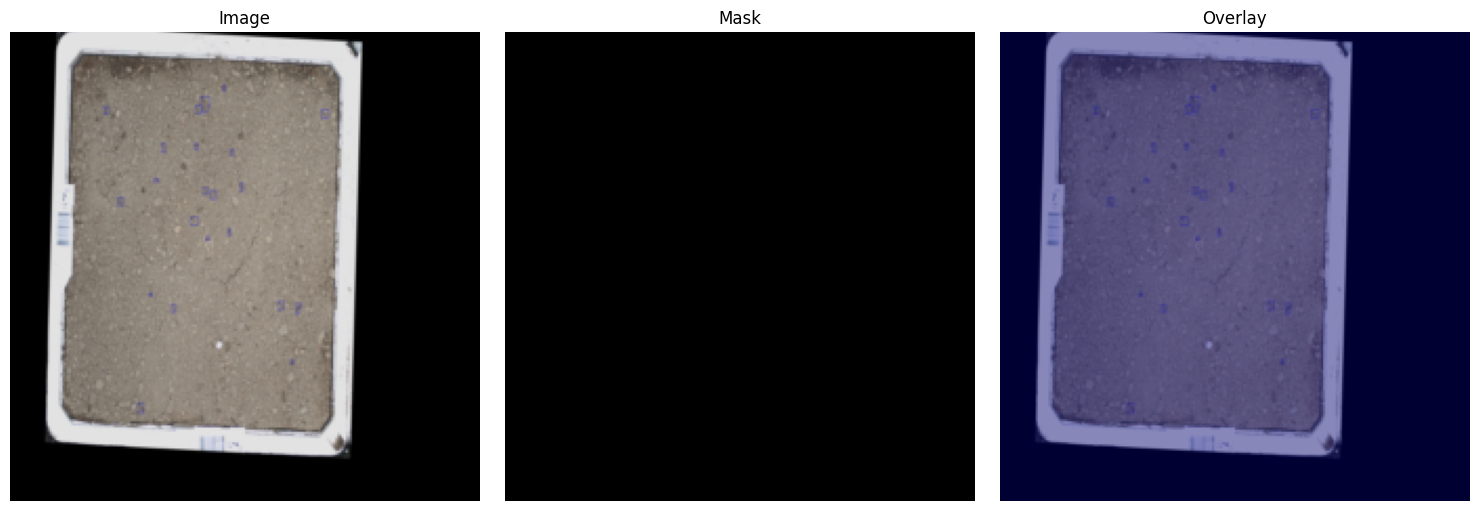

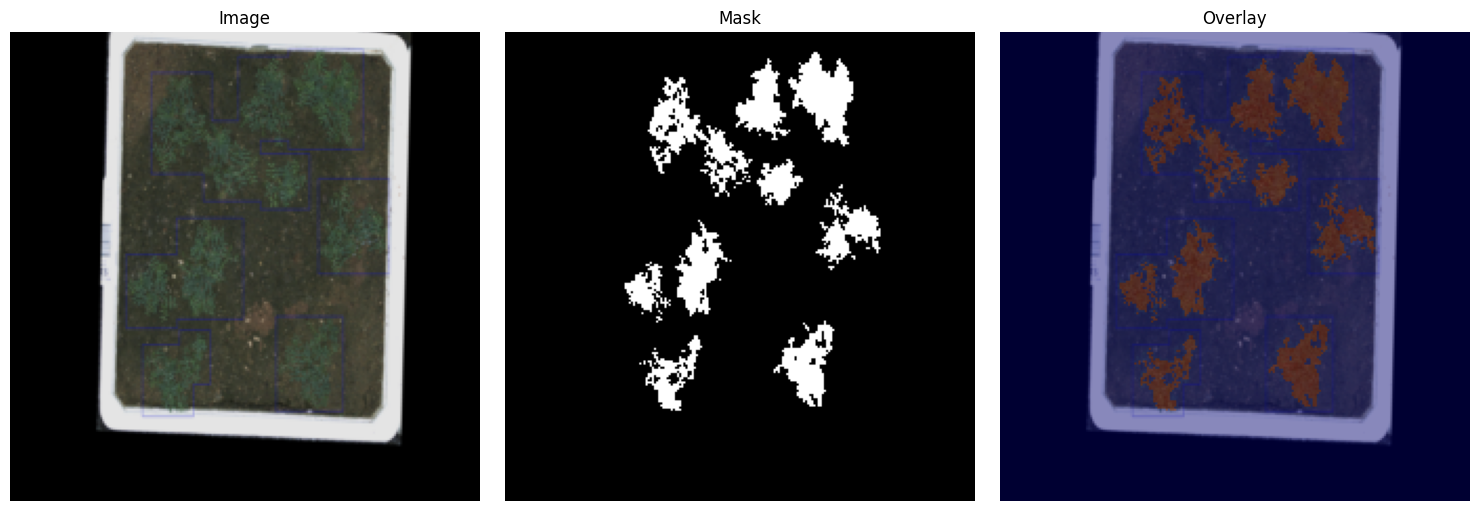

In [8]:
def imshow(img, mask):
    npimg = img.numpy().astype(float)
    npmask = mask.numpy().astype(float) * 256
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Image')
    axes[1].imshow(npmask, cmap='gray', vmin=0, vmax=1)
    axes[1].axis('off')
    axes[1].set_title('Mask')
    axes[2].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[2].imshow(npmask, alpha=0.4, cmap='jet', vmin=0, vmax=1)
    axes[2].axis('off')
    axes[2].set_title('Overlay')
    plt.tight_layout()
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

n_show = 2
for img, mask in zip(images[:n_show], labels[:n_show]):
  imshow(img, mask)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Функции для получения метрик

In [10]:
def get_accuracy(output, mask) -> float:
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def get_mIoU(output, mask, smooth=1e-10, n_classes=2) -> float:
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        output = output.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        iou_per_class = []

        for clas in range(0, n_classes):
            true_class = output == clas
            true_label = mask == clas
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

Функции для обучения нейросетей

In [11]:
def train(model, criterion, optimizer, epochs: int, n_print: int) -> tuple:
    train_accuracies = []
    train_iou_scores = []
    test_accuracies = []
    test_iou_scores = []
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        iou_score = 0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            iou_score += get_mIoU(outputs, labels)
            accuracy += get_accuracy(outputs, labels)
        test_accuracy = 0
        test_iou_score = 0
        with torch.no_grad():
            for _, data in enumerate(testloader):
                image_tiles, mask_tiles = data
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                outputs = model(image)
                test_iou_score += get_mIoU(outputs, mask)
                test_accuracy += get_accuracy(outputs, mask)
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_accuracy = accuracy / len(trainloader)
        epoch_test_accuracy = test_accuracy / len(testloader)
        epoch_train_iou = iou_score / len(trainloader)
        epoch_test_iou = test_iou_score / len(testloader)
        train_accuracies.append(epoch_train_accuracy)
        train_iou_scores.append(epoch_train_iou)
        test_accuracies.append(epoch_test_accuracy)
        test_iou_scores.append(epoch_test_iou)
        if (epoch + 1) % n_print == 0:
            print(f"Epoch {epoch + 1}:")
            print(f"  Train Loss: {epoch_train_loss:.4f}")
            print(f"  Train Accuracy: {epoch_train_accuracy:.4f} | Train mIoU: {epoch_train_iou:.4f}")
            print(f"  Test Accuracy:  {epoch_test_accuracy:.4f} | Test mIoU:  {epoch_test_iou:.4f}")
            print("-" * 60)

    return (train_accuracies, train_iou_scores, test_accuracies, test_iou_scores)

def get_criterion_optimizer(model):
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 3.0]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return criterion, optimizer

def show_metrics(metrics_dict, metric_name="Accuracy", title="Model Comparison"):
    """
    Визуализирует метрики для нескольких моделей
    """
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", n_colors=len(metrics_dict)*2)

    for idx, (model_name, (train_metric, test_metric)) in enumerate(metrics_dict.items()):
        plt.plot(train_metric,
                 label=f'{model_name} - Train',
                 color=palette[idx*2],
                 linestyle='-',
                 linewidth=2)

        plt.plot(test_metric,
                 label=f'{model_name} - Test',
                 color=palette[idx*2+1],
                 linestyle='--',
                 linewidth=2)

    plt.title(f"{title} ({metric_name})", fontsize=14, pad=20)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

Функция для предсказания результатов

In [ ]:
def predict(model, loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    n_show = 2
    predicted = model(images.to(device)).to("cpu")
    for img, output, mask in zip(images[:n_show], predicted[:n_show], labels[:n_show]):
        imshow(img, mask)
        output = torch.argmax(output, dim=0)
        imshow(img, output.detach())

Определение критерия ошибки и оптимизатора, наиболее подходящего для модели

In [13]:
model_unet = smp.Unet("mobilenet_v2", encoder_weights="imagenet", classes=2)
model_unet = model_unet.to(device)
criterion, optimizer = get_criterion_optimizer(model_unet)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [14]:
train_acc_unet, train_iou_unet, test_acc_unet, test_iou_unet = train(model_unet, criterion, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 4.5453
  Train Accuracy: 0.7761 | Train mIoU: 0.4214
  Test Accuracy:  0.8594 | Test mIoU:  0.4695
------------------------------------------------------------
Epoch 2:
  Train Loss: 3.4875
  Train Accuracy: 0.9001 | Train mIoU: 0.5190
  Test Accuracy:  0.9286 | Test mIoU:  0.5348
------------------------------------------------------------
Epoch 3:
  Train Loss: 2.8263
  Train Accuracy: 0.9529 | Train mIoU: 0.6053
  Test Accuracy:  0.9604 | Test mIoU:  0.5887
------------------------------------------------------------
Epoch 4:
  Train Loss: 2.4106
  Train Accuracy: 0.9654 | Train mIoU: 0.6429
  Test Accuracy:  0.9756 | Test mIoU:  0.6412
------------------------------------------------------------
Epoch 5:
  Train Loss: 2.0474
  Train Accuracy: 0.9765 | Train mIoU: 0.6984
  Test Accuracy:  0.9782 | Test mIoU:  0.6663
------------------------------------------------------------
Epoch 6:
  Train Loss: 1.7978
  Train Accuracy: 0.9811 | Train mIoU: 0.7313
  Test Ac

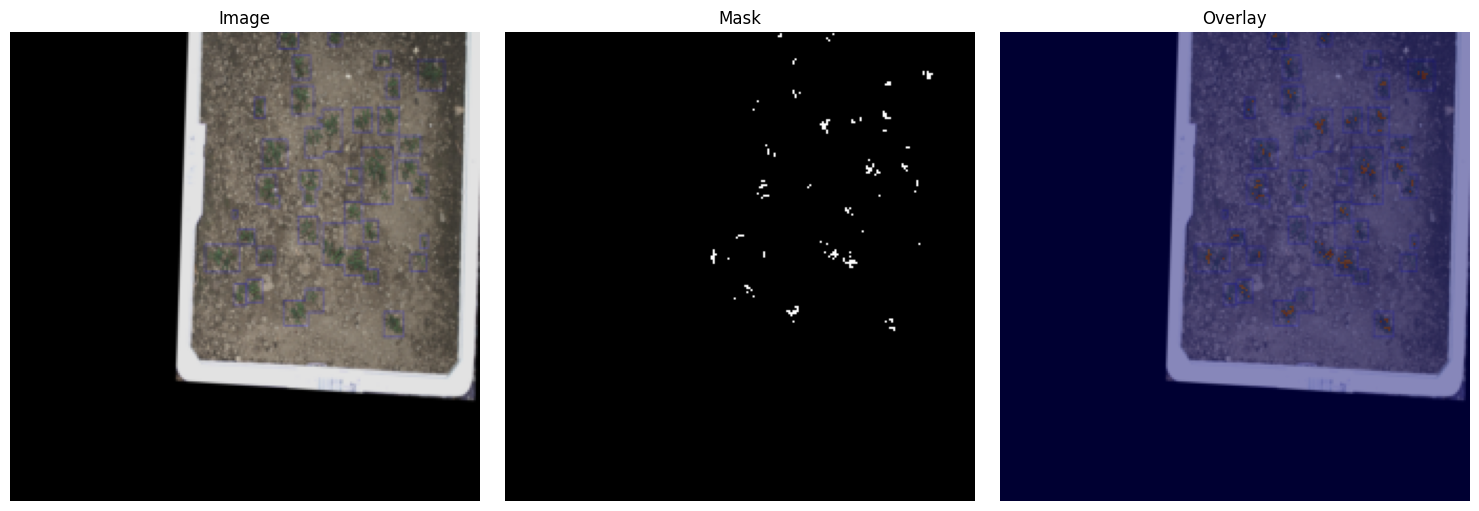

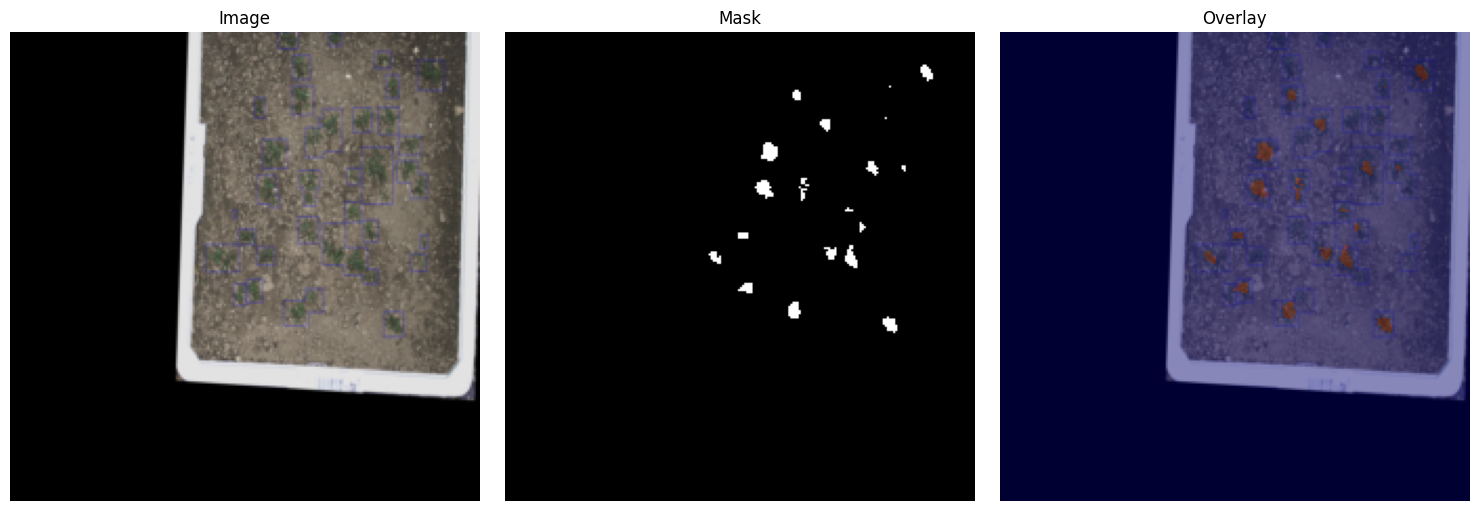

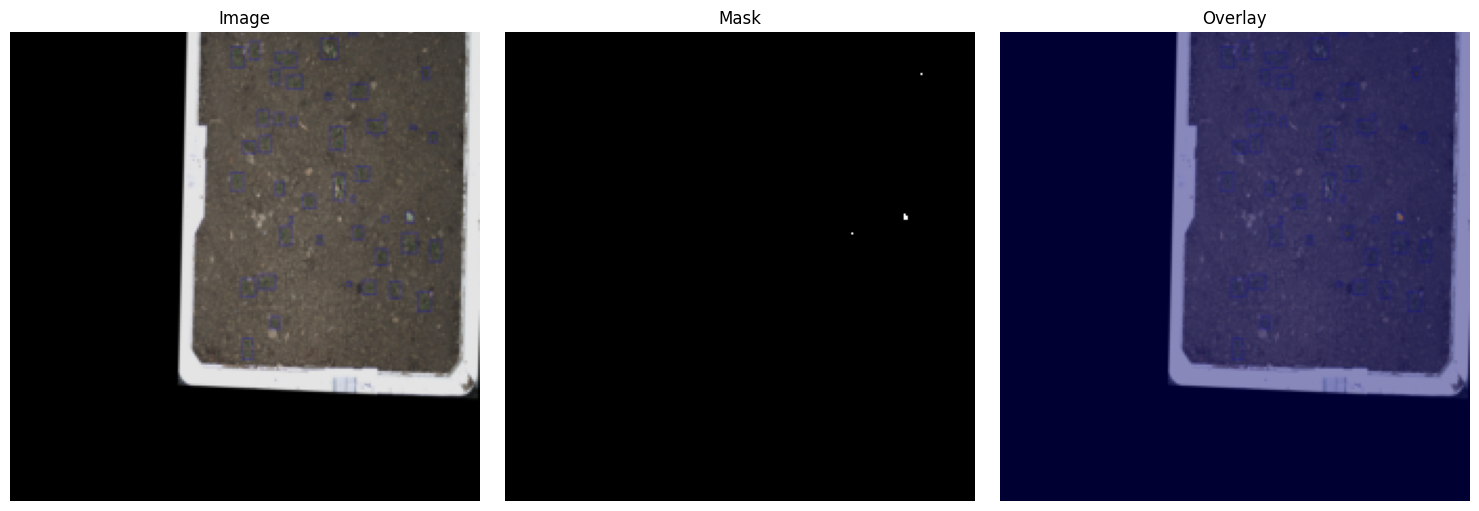

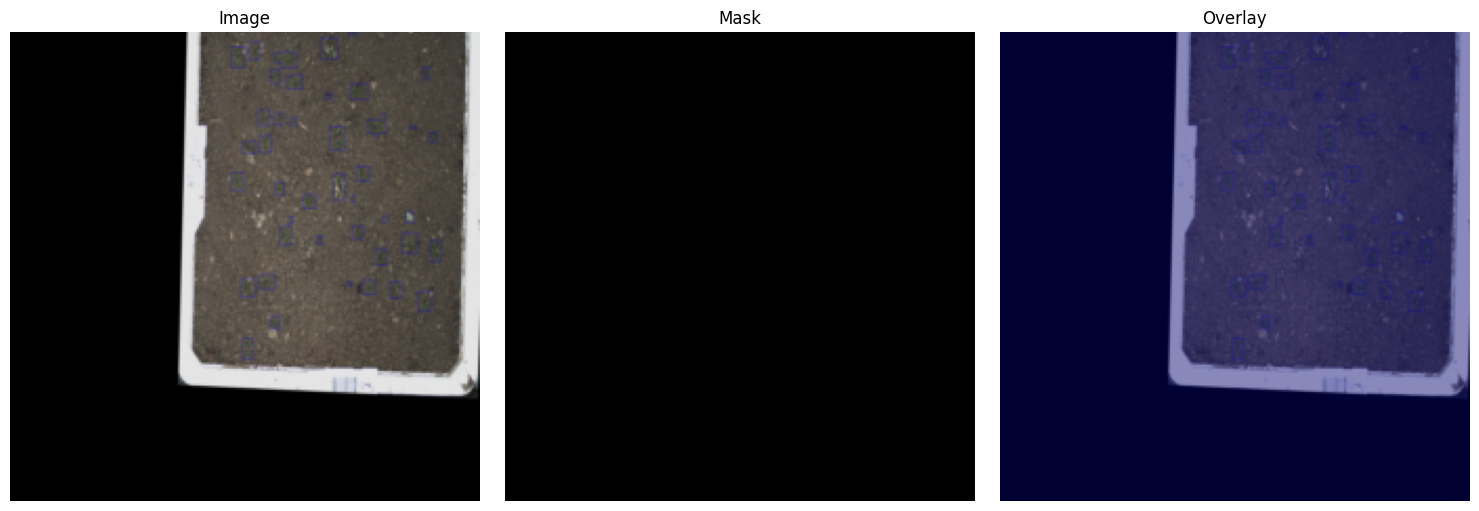

In [15]:
predict(model_unet, testloader)

Код архитектуры кастомной модели

In [16]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Custom2Conv(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(Custom2Conv, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Обучение кастомной модели

In [17]:
model_custom_2conv = Custom2Conv().to(device)
criterion, optimizer = get_criterion_optimizer(model_custom_2conv)

In [18]:
train_acc_custom_2conv, train_iou_custom_2conv, test_acc_custom_2conv, test_iou_custom_2conv = train(model_custom_2conv, criterion, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 4.2529
  Train Accuracy: 0.8115 | Train mIoU: 0.4606
  Test Accuracy:  0.9477 | Test mIoU:  0.5791
------------------------------------------------------------
Epoch 2:
  Train Loss: 2.9993
  Train Accuracy: 0.9661 | Train mIoU: 0.6598
  Test Accuracy:  0.9811 | Test mIoU:  0.6922
------------------------------------------------------------
Epoch 3:
  Train Loss: 2.5240
  Train Accuracy: 0.9794 | Train mIoU: 0.7171
  Test Accuracy:  0.9819 | Test mIoU:  0.7024
------------------------------------------------------------
Epoch 4:
  Train Loss: 2.2546
  Train Accuracy: 0.9815 | Train mIoU: 0.7292
  Test Accuracy:  0.9873 | Test mIoU:  0.7319
------------------------------------------------------------
Epoch 5:
  Train Loss: 2.0983
  Train Accuracy: 0.9818 | Train mIoU: 0.7289
  Test Accuracy:  0.9879 | Test mIoU:  0.7428
------------------------------------------------------------
Epoch 6:
  Train Loss: 1.9688
  Train Accuracy: 0.9839 | Train mIoU: 0.7285
  Test Ac

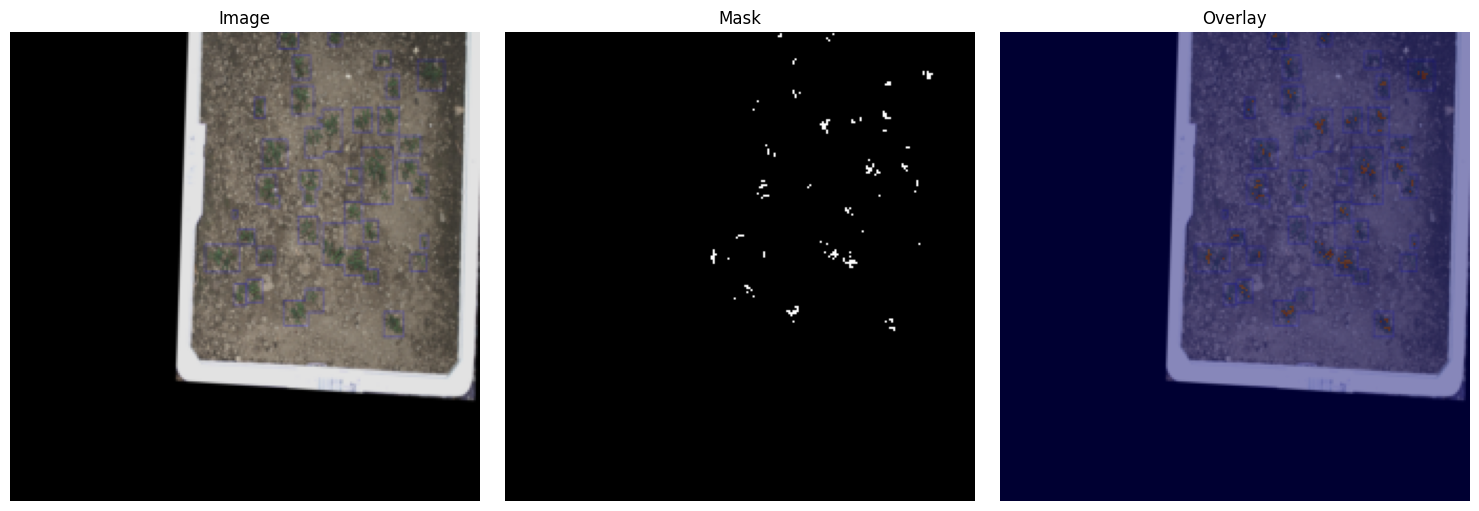

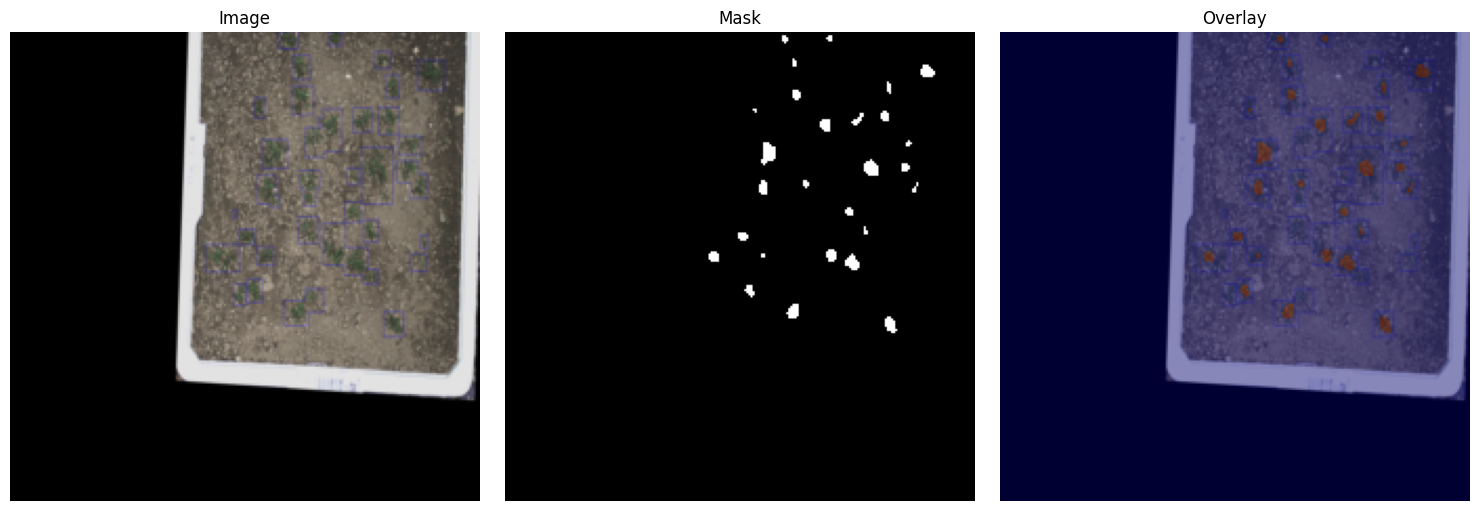

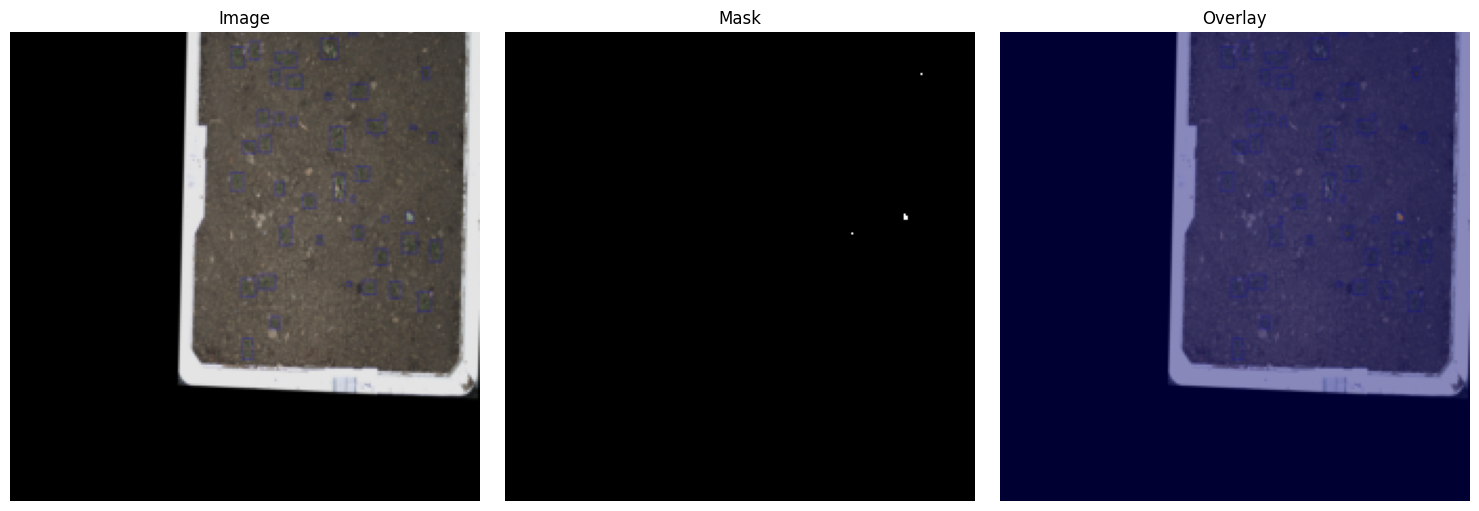

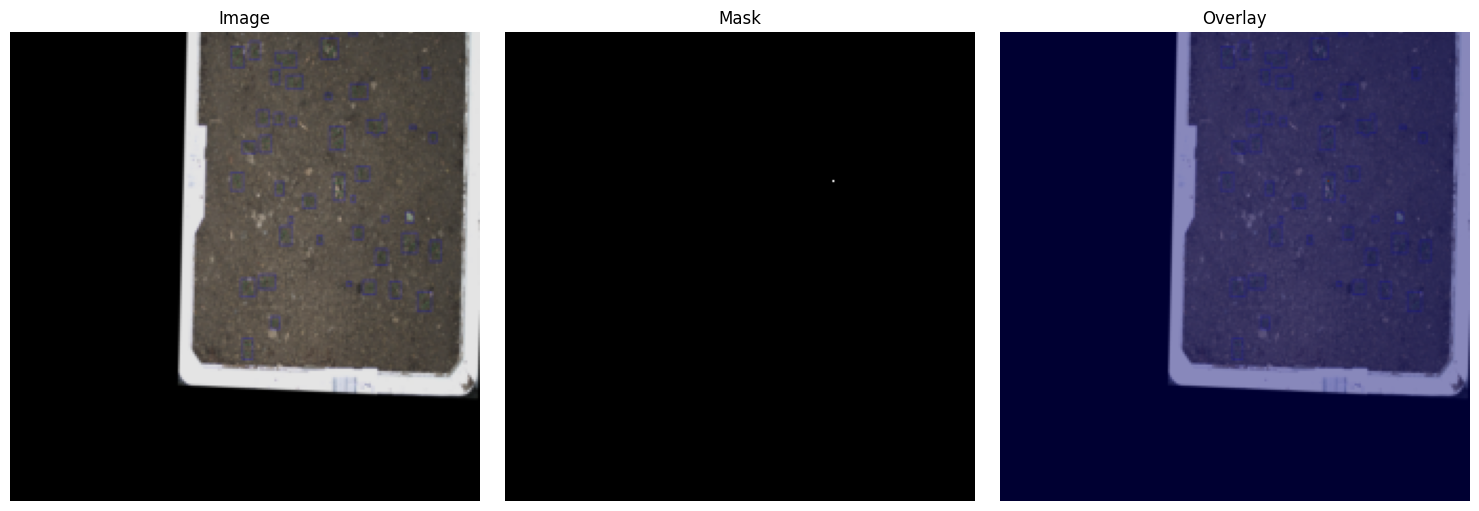

In [19]:
predict(model_custom_2conv, testloader)

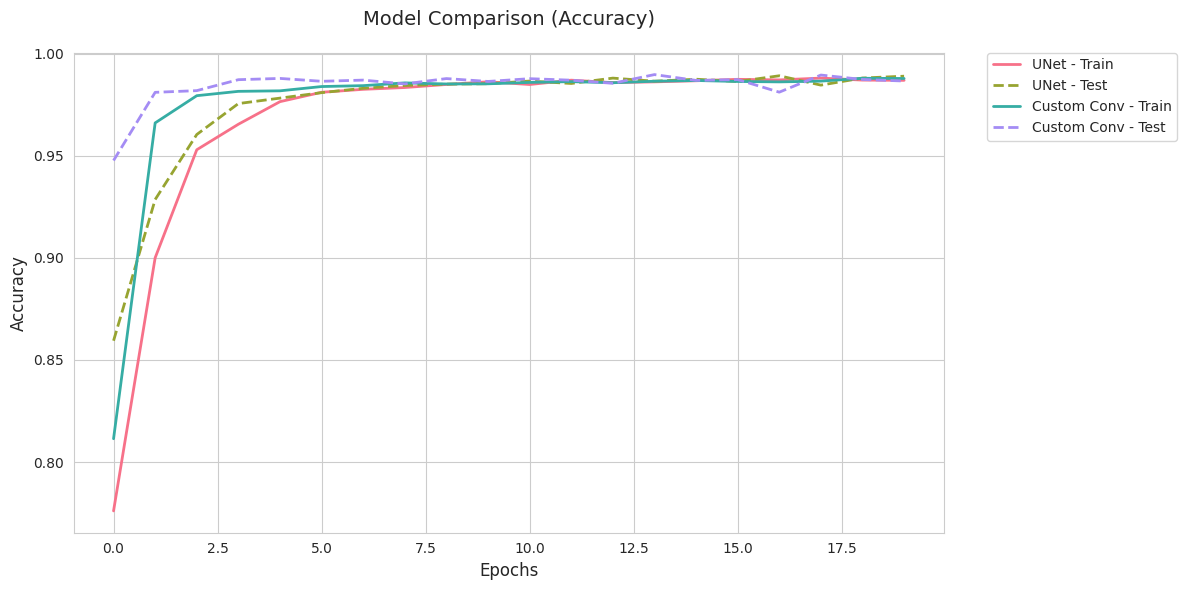

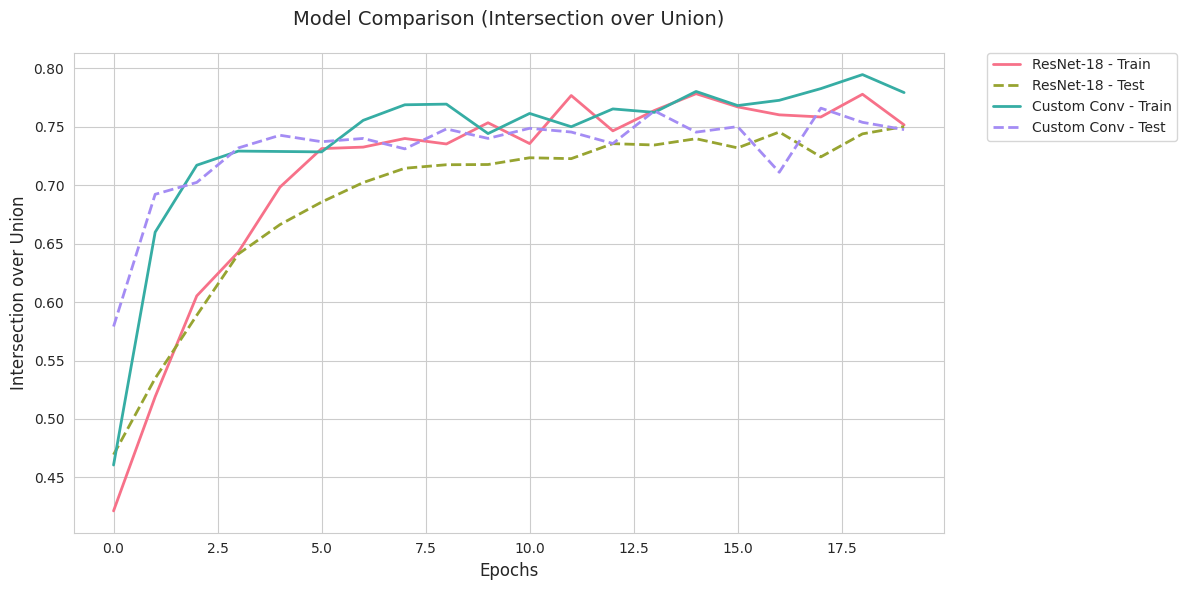

In [20]:
accuracy_data = {
    "UNet": (train_acc_unet, test_acc_unet),
    "Custom Conv": (train_acc_custom_2conv, test_acc_custom_2conv),
}
iou_data = {
    "ResNet-18": (train_iou_unet, test_iou_unet),
    "Custom Conv": (train_iou_custom_2conv, test_iou_custom_2conv),
}
show_metrics(accuracy_data, metric_name="Accuracy")
show_metrics(iou_data, metric_name="Intersection over Union")